## 1. Problem statement

Task: TensorFlow is an open-source machine learning framework developed by Google for the sole purpose of building and training machine learning models.

One of the datasets under the Tensorflow Image libraries is a malaria dataset which contains approximately 27,500 cell images of parasitized and uninfected cells from thin blood smear slide images of segmented cells.

 **Objective**  

 To create a model which is able to classify whether a blood smear is uninfected or parasitized.


###  Classes

- parasitized  
- uninfected

###  Import Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

2024-05-12 15:08:20.707858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 15:08:20.707967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 15:08:20.859855: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.__version__

'2.15.0'

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
#declaring predefined variables

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

###  Load Dataset

In [6]:
dataset, info = tfds.load("malaria",split="train",  batch_size=BATCH_SIZE, shuffle_files=True, with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteB3YUSD/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


##  2. Data Understanding

In [7]:
print("Numeber of classes: ", info.features["label"].num_classes)
print("Class Names: ", info.features["label"].names)

Numeber of classes:  2
Class Names:  ['parasitized', 'uninfected']


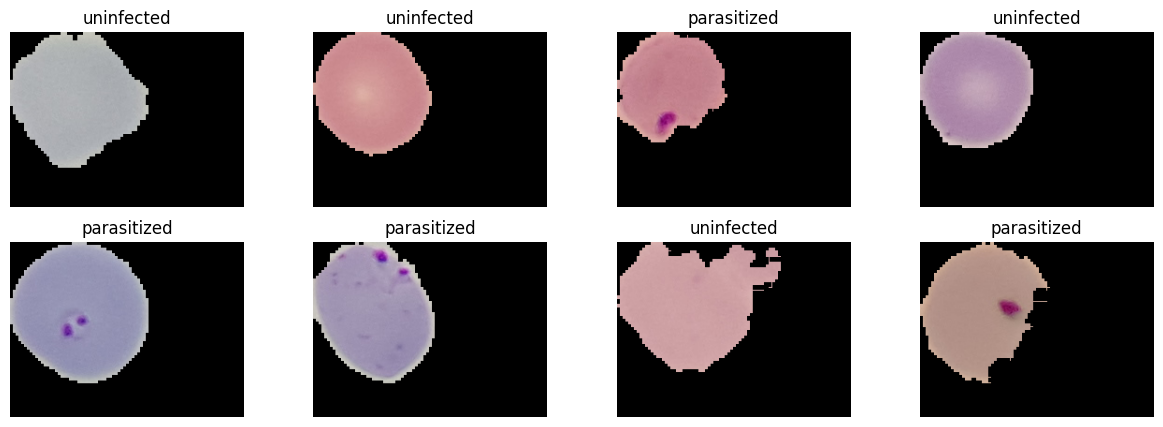

In [8]:
# showing samples

plt.figure(figsize=(15,5))

for image, label in dataset.take(1):
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(info.features["label"].names[label[i].numpy()])
        plt.axis("off")

##  3. Data Preproccessing and Feature Engineering

In [9]:
#we have a total of 862 batches of 32

len(dataset)

862

In [10]:
#function to split data into train validation and test in the ratio of 80:10:10 respectively

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Normalization and Resizing

In [12]:
#we resize the images to be of size 256 by 256
#then, we normalize the features by dividing it by 255

def process_image(img,label):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_with_crop_or_pad(img,IMAGE_SIZE,IMAGE_SIZE)
    img = tf.reshape(img, (-1,IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    label = tf.reshape(label, (-1,1))
    return img, label


In [13]:
train_ds = train_ds.map(process_image)
val_ds = val_ds.map(process_image)
test_ds = test_ds.map(process_image)

## 4. Modelling

### Model Architecture

In [14]:
model = Sequential()

In [15]:
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3),  activation='relu'))
model.add(MaxPooling2D()),
model.add(Conv2D(64, (3,3),  activation='relu'))
model.add(MaxPooling2D()),
model.add(Conv2D(64, (3,3),  activation='relu'))
model.add(MaxPooling2D()),
model.add(Conv2D(32, (3,3),  activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
#summary of our model

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,801 (596.88 KB)

 Trainable params: 152,801 (596.88 KB)

 Non-trainable params: 0 (0.00 B)

###  Compiling the Model

In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Training

In [18]:
logdir='logs'

In [19]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
hist = model.fit(
      train_ds,
      batch_size=BATCH_SIZE,
      validation_data=val_ds,
      verbose=1,
      epochs=25,
    callbacks=[tensorboard_callback]
  )

Epoch 1/25
  2/689 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.5469 - loss: 0.6929   

I0000 00:00:1715526685.454144     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 74ms/step - accuracy: 0.7712 - loss: 0.4169 - val_accuracy: 0.9564 - val_loss: 0.1491
Epoch 2/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 66ms/step - accuracy: 0.9556 - loss: 0.1424 - val_accuracy: 0.9553 - val_loss: 0.1425
Epoch 3/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 55s 66ms/step - accuracy: 0.9611 - loss: 0.1246 - val_accuracy: 0.9575 - val_loss: 0.1188
Epoch 4/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 66ms/step - accuracy: 0.9586 - loss: 0.1296 - val_accuracy: 0.9608 - val_loss: 0.1131
Epoch 5/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 66ms/step - accuracy: 0.9584 - loss: 0.1277 - val_accuracy: 0.9640 - val_loss: 0.0999
Epoch 6/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - accuracy: 0.9616 - loss: 0.1112 - val_accuracy: 0.9622 - val_loss: 0.1131
Epoch 7/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 66ms/step - accuracy: 0.9658 - loss: 0.1067 - val_accuracy: 0.9622 - val_loss: 0.1159
Epoch 8/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 63ms/step - accuracy: 0.9645 - loss: 0.1047 - val_accurac

### Plot Performance

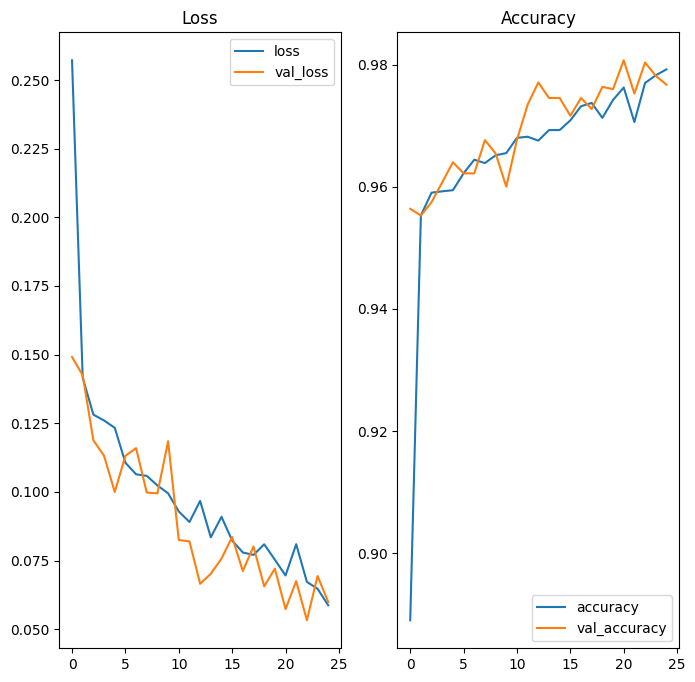

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss') 
 
   
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'],  label='accuracy')
plt.plot(hist.history['val_accuracy'],  label='val_accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.show() 

## 5. Testing

In [22]:
model.evaluate(test_ds)  

87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9712 - loss: 0.0868


[0.07537022233009338, 0.9757070541381836]

### Run Prediction on Sample 

In [23]:
class_names = ['uninfected', 'parasitized'] 

first image to predict
actual label: uninfected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
predicted label: uninfected


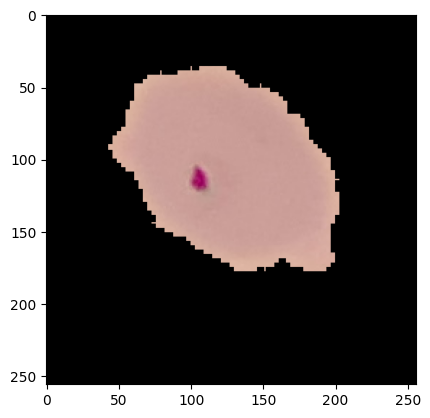

In [31]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy()
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label[0]])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[round(batch_prediction[0][0])])

## Saving the model

In [25]:
model.save("malaria.h5")